In [31]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle
import xgboost as xgb

import h5py
import renom as rm
from renom import Sequential
from renom import Dense, Relu
from renom import Adam
from sklearn.externals import joblib

In [32]:
searched_date='original'
df=pd.read_csv('intermediate_data/preprocessed_spec_iqr1_{}.csv'.format(searched_date))
df=df.drop(df.columns[0],axis=1)
df=df.astype('float')

In [33]:
df_s = df.copy()

col_std=[]
col_mean=[]
for col in df.columns:
    v_std = df[col].std()
    v_mean = df[col].mean()
    col_std.append(v_std)
    col_mean.append(v_mean)
    df_s[col] = (df_s[col] - v_mean) / v_std

In [34]:
Xnn = df_s.drop('price', axis=1).as_matrix()
ynn = df_s['price']
indices=df_s.index
#データをわける
Xnn_train, Xnn_test, ynn_train, ynn_test, nn_index_train,nn_index_test = train_test_split(Xnn, ynn,indices, test_size = 0.1, random_state = 666)
ynn_train=ynn_train.reshape(ynn_train.shape[0],-1)
ynn_test=ynn_test.reshape(ynn_test.shape[0],-1)

/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


In [35]:
X = df.drop('price', axis=1).as_matrix()
y = df['price']
indices=df.index

#データをわける
X_train, X_test, y_train, y_test, index_train,index_test = train_test_split(X, y,indices, test_size = 0.1, random_state = 666)

### NN

In [36]:
nn = Sequential([
    Dense(15),
    Relu(),
    Dense(10),
    Relu(),
    Dense(8),
    Relu(),
    Dense(4),
    Relu(),
    Dense(1)
])
# Load and set the weight parameters
nn.load('model/model_nn_{}.h5'.formart(searched_date))

### RandomForest

In [37]:
#モデルのロード
rf = joblib.load('model/model_rf_{}.pickle'.format(searched_date))

### XGBoost

In [38]:
#モデルのロード
f = open('model/model_xgb_{}.pickle'.format(searched_date),'rb')
xgb=pickle.load(f)

### prediction

In [39]:
xgb_train_pred =xgb.predict(X_train).reshape(-1, 1)
xgb_test_pred = xgb.predict(X_test).reshape(-1, 1)

In [40]:
rf_train_pred =rf.predict(X_train).reshape(-1, 1)
rf_test_pred = rf.predict(X_test).reshape(-1, 1)

In [41]:
ynn_train_pred = nn(Xnn_train)
ynn_test_pred = nn(Xnn_test)
nn_train_pred = ynn_train_pred[:,:1] * col_std[0] + col_mean[0]
nn_test_pred = ynn_test_pred[:,:1] * col_std[0] + col_mean[0]

nn_train_true = ynn_train[:,:1].reshape(-1, 1) * col_std[0] + col_mean[0]
nn_test_true = ynn_test[:,:1].reshape(-1, 1) * col_std[0] + col_mean[0]

### Ensemble 

In [60]:
xgb_cf=0.3
rf_cf=0
nn_cf=0.7
# ens_train=(xgb_train_pred+rf_train_pred+np.array(nn_train_pred))/3
# ens_test=(xgb_test_pred+rf_test_pred+np.array(nn_test_pred))/3
ens_train=xgb_cf*xgb_train_pred+rf_cf*rf_train_pred+nn_cf*np.array(nn_train_pred)
ens_test=xgb_cf*xgb_test_pred+rf_cf*rf_test_pred+nn_cf*np.array(nn_test_pred)

In [61]:
from sklearn.metrics import mean_squared_error
print('rmse_train=',np.sqrt(mean_squared_error(y_train,ens_train)))
print('rmse_test=',np.sqrt(mean_squared_error(y_test,ens_test)))

from sklearn.metrics import r2_score
print('r2_train=',r2_score(y_train,ens_train))
print('r2_test=',r2_score(y_test,ens_test))

rmse_train= 97.38273990623773
rmse_test= 302.7961995559829
r2_train= 0.9978140138526709
r2_test= 0.9786987642546396


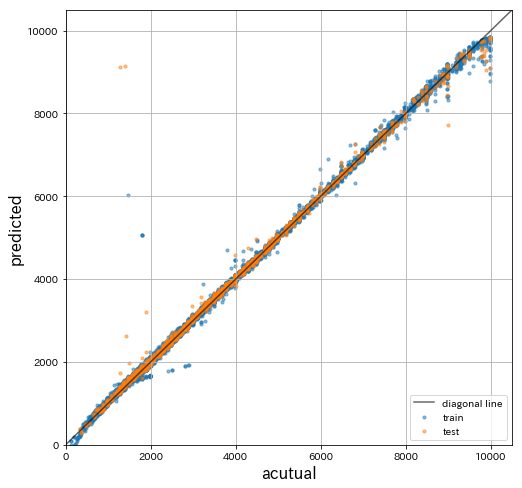

In [62]:
u_lim=10500
l_lim=0
plt.figure(figsize=(8, 8))
plt.plot([l_lim,u_lim], [l_lim,u_lim], c='k', alpha=0.6, label = 'diagonal line') # diagonal line
plt.scatter(y_train,ens_train,label='train',alpha=0.5,s=10)
plt.scatter(y_test,ens_test,label='test',alpha=0.5,s=10)
plt.xlim(l_lim,u_lim)
plt.ylim(l_lim,u_lim)
plt.xlabel('acutual', fontsize=16)
plt.ylabel('predicted', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [63]:
dif_train=abs(ens_train[:,0]-y_train)
dif_test=abs(ens_test[:,0]-y_test)
bad_pred_train=dif_train[dif_train>500]
bad_pred_test=dif_test[dif_test>500]
bad_index=list(bad_pred_train.index)
bad_index.extend(list(bad_pred_test.index))
df_bad_pred=df.loc[bad_index,:]

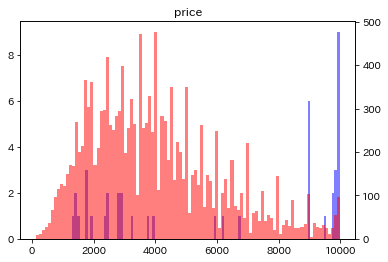

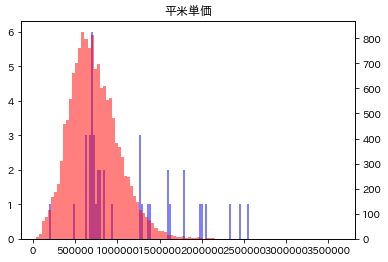

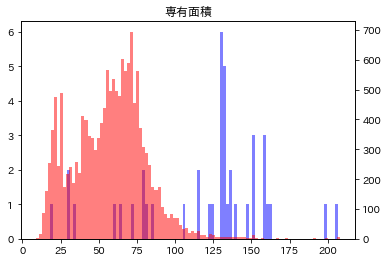

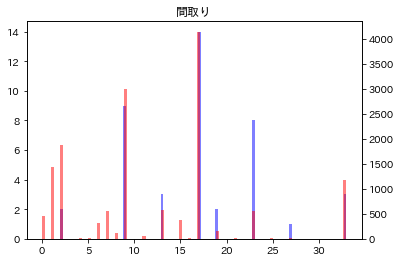

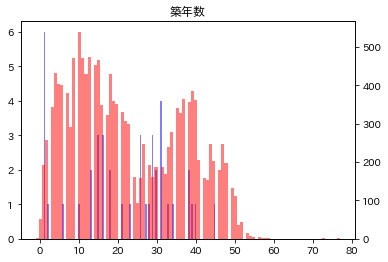

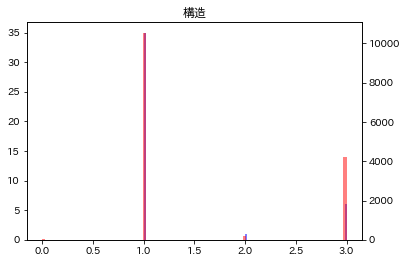

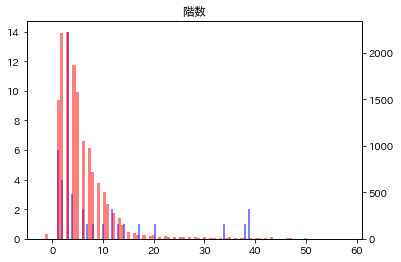

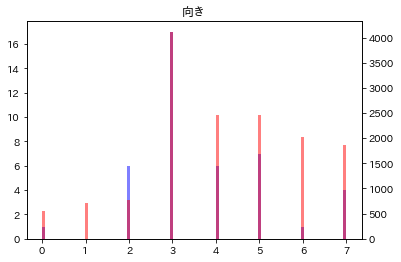

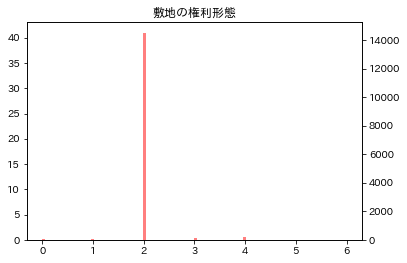

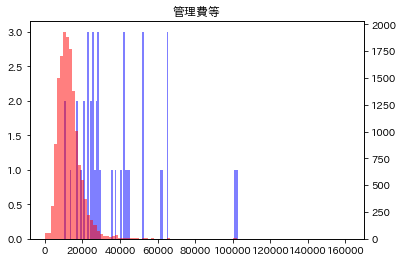

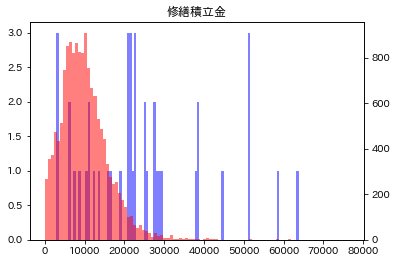

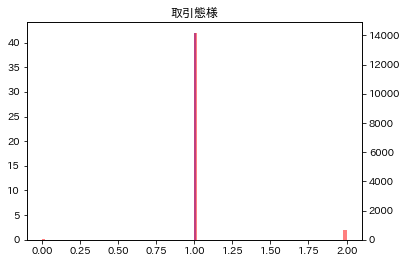

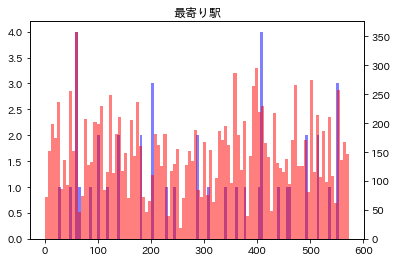

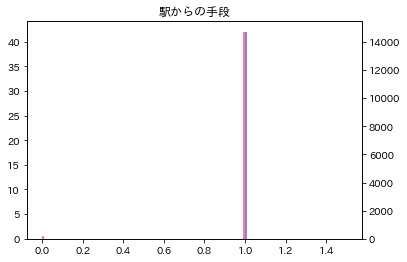

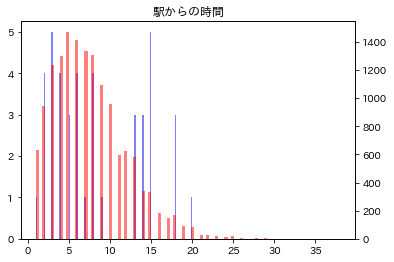

In [64]:
for col in df_bad_pred:
    fig, ax1 = plt.subplots()
    ax1.hist(df_bad_pred[col],bins=100,color='blue', alpha=0.5)
    ax2 = ax1.twinx()  # 2つのプロットを関連付ける
    ax2.hist(df[col],bins=100,color='red', alpha=0.5)
    plt.title(col)
    plt.show()

### 予測を外しているレコードの確認

In [65]:
index=list(index_train)
index.extend(list(index_test))
prediction=list(ens_train[:,0])
prediction.extend(list(ens_test[:,0]))
df_pred=pd.DataFrame()
df_pred['index']=index
df_pred['prediction']=prediction
df_pred=df_pred.set_index('index')
df_all=df_pred.join(df)
df_all.loc[bad_index,:]

,prediction,price,平米単価,専有面積,間取り,築年数,構造,階数,向き,敷地の権利形態,管理費等,修繕積立金,取引態様,最寄り駅,駅からの手段,駅からの時間
index,,,,,,,,,,,,,,,,
10787,8979.896484,9980.0,733300.0,136.10,23.0,31.0,1.0,3.0,3.0,2.0,37500.0,25860.0,1.0,287.0,1.0,4.0
7535,1903.148499,2800.0,1590300.0,130.80,17.0,13.0,1.0,39.0,7.0,2.0,25220.0,38680.0,1.0,141.0,1.0,14.0
3482,7231.756470,6680.0,1999500.0,33.41,33.0,21.0,1.0,3.0,3.0,2.0,14000.0,2910.0,1.0,101.0,1.0,3.0
13008,9278.678467,9800.0,849700.0,115.34,9.0,15.0,1.0,4.0,2.0,2.0,22840.0,25370.0,1.0,183.0,1.0,13.0
8848,8332.613281,8990.0,678500.0,132.50,23.0,29.0,2.0,3.0,3.0,2.0,28000.0,22600.0,1.0,554.0,1.0,15.0
2330,9277.368164,9890.0,498000.0,198.61,17.0,30.0,3.0,6.0,3.0,2.0,62600.0,58680.0,1.0,538.0,1.0,4.0
10156,9291.974365,9980.0,767200.0,130.09,17.0,10.0,1.0,7.0,7.0,2.0,16900.0,15870.0,1.0,118.0,1.0,8.0
4762,9100.850830,9980.0,797400.0,125.16,17.0,38.0,1.0,3.0,7.0,2.0,40680.0,27400.0,1.0,63.0,1.0,9.0
12354,4692.343506,3800.0,2339600.0,131.65,13.0,1.0,1.0,3.0,4.0,2.0,102700.0,13790.0,1.0,101.0,1.0,4.0


In [66]:
df_all.to_csv('intermediate_data/prediction_ensemble_{}.csv'.format(searched_date))